## Anisotropy and intrinsic dimension

In [25]:
import math
import numpy as np
import torch
import random
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

import matplotlib.pyplot as plt

In [26]:
device = torch.device('cuda:0')

In [ ]:
def calculate_anisotropy_torch(emb, fast=False, pm_n_iters=100):
    """
    Calculate the anisotropy of a set of embeddings.

    Parameters:
    emb: torch tensor of shape (n_samples, n_features) representing the embeddings.
    fast: bool - if True, employs Power Method to find the 1st singular value and 
        Frobenius norm as the sum of singular values. Approximately 2 times faster.
    pm_n_iters: int - number of iterations of Power method. Used if fast=True.

    Returns:
    float: The anisotropy value.
    """
    # embeddings = torch.FloatTensor(embeddings).to(DEVICE)
    embeddings = emb - emb.mean(dim=0, keepdim=True) # Center the embeddings
    if fast:
        x = torch.randn(embeddings.shape[0], device=embeddings.device, dtype=emb.dtype) # Init 1st eigenvec
        for _ in range(pm_n_iters):       
            x /= torch.norm(x)
            x = x @ embeddings
            x /= torch.norm(x)
            x = embeddings @ x 
        sigma = torch.norm(x)
        anisotropy = float(sigma ** 2 / torch.norm(embeddings) ** 2)
    else:
        U, S, Vh = torch.linalg.svd(embeddings, full_matrices=False)
        cov_einvalues = (S*S) / (embeddings.shape[0] - 1)
        
        anisotropy = float(cov_einvalues.max() / cov_einvalues.sum())
    return anisotropy

def intrinsic_dimension(emb, debug=False, reduction_factor=5):
    """
    emb: n x dim torch tensor
    """
    with torch.no_grad():
        eps = 1e-8
        embeddings = emb.to(torch.float64)
        embeddings = embeddings - embeddings.mean(dim=0, keepdim=True)
        avg_len = (embeddings*embeddings).sum(dim=1).sqrt().mean()
        embeddings = embeddings / avg_len

        r1 = []
        r2 = []
        n = len(embeddings)
        for i in range(n):
            dsts = torch.nn.functional.pairwise_distance(
                embeddings[i, None, :],
                embeddings[None, :, :],
                eps=0
            )[0]
            dsts = torch.cat([dsts[:i], dsts[i+1:]])
            r1.append(torch.kthvalue(dsts, k=1)[0])
            r2.append(torch.kthvalue(dsts, k=2)[0])
        r1 = torch.tensor(r1).to(device)
        r2 = torch.tensor(r2).to(device)
        bad_cases = (r1 < eps)
        r1[bad_cases] = eps
        r2[bad_cases] = eps
        mu = r2 / r1
        mu[bad_cases] = -1
    
        mu, ind = torch.sort(mu)
        all_mu = mu.clone().cpu().detach()
        useless_items = int((mu <= 1+eps).sum()) 
        mu = mu[useless_items:]
        n = mu.shape[0]
        if debug:
            print('Removed points: ', useless_items)
            plt.plot(mu.cpu().detach().numpy())
            plt.show()

        f_emp = torch.arange(1+useless_items, n + 1 + useless_items, device=device) / (n + useless_items)
        num_dots_to_use = min(n  // reduction_factor, n - 1)
        
        mu_log = torch.log(mu)[:num_dots_to_use]
        dist_log = -torch.log(1 - f_emp)[:num_dots_to_use]

        if debug:
            print('Regression points:', len(mu_log))
            plt.scatter(mu_log.cpu().detach().numpy(), dist_log.cpu().detach().numpy(), marker='.')
            plt.show()

        dim = float((mu_log*dist_log).sum() / (mu_log*mu_log).sum())

        if debug:
            print('Dim: ', dim)
    return float(dim) #, all_mu

def get_est_svd(X, Y):
    """
    X -- torch tensor with shape [n_samples, dim]
    Y -- torch tensor with shape [n_samples, dim]

    Approximates Y matrix with linear transformation Y = XA
    """
    U, S, Vh = torch.linalg.svd(X, full_matrices=False)
    A_estimation = Vh.T * (1 / S)[None, ...] @ U.T @ Y # Y=XA
    Y_est =  X @ A_estimation
    return Y_est

def procrustes_similarity(x, y):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad():
        
        X = x - x.mean(dim=0, keepdim=True)
        Y = y - y.mean(dim=0, keepdim=True)
    
        X = X / X.norm()
        Y = Y / Y.norm()
    
        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

def procrustes_similarity_centered(x, y0):
    """
    x -- torch tensor with shape [n_samples, dim]
    y -- torch tensor with shape [n_samples, dim]
    """
    with torch.no_grad():
        y = y0 - x
        
        X = x - x.mean(dim=0, keepdim=True)
        Y = y - y.mean(dim=0, keepdim=True)
    
        X = X / X.norm()
        Y = Y / Y.norm()
    
        Y_estimation = get_est_svd(X, Y)
    
        y_error = (Y_estimation - Y).square().sum()
        sim = float(1 - y_error)
    return sim

In [33]:
TEXT_PATH = "./enwik88.txt"

with open(TEXT_PATH) as f:
    text = f.read()

random.seed(0)
STEPS = 128
N_CHARS = 512
steps = min(STEPS, len(text) // N_CHARS)
start_idxs = random.sample(list(range(len(text) // N_CHARS)), steps)

def get_embeddings(model, start_idxs=start_idxs):
    layer2embs = {}
    n_chars = N_CHARS
    with torch.no_grad():
        emb_layer = model.get_input_embeddings()
        for j in tqdm(start_idxs, desc='Collecting embeddings'):
            j = j * n_chars
            tokens = tokenizer(text[j :j+n_chars], return_tensors="pt").to(device)['input_ids']
            outputs = model(tokens, output_hidden_states=True)
            hidden_states = outputs.hidden_states
            for i, emb in enumerate(hidden_states):
                if i in layer2embs:
                    layer2embs[i] += list(emb.cpu().detach()[0])
                else:
                    layer2embs[i] = list(emb.cpu().detach()[0])
        for i in range(len(hidden_states)):
            layer2embs[i] = torch.stack(layer2embs[i])
        return layer2embs

In [ ]:
## Compare implementations of Anisotropy estimation
import time 

STEPS = 1024 # 128
N_CHARS = 512
steps = min(STEPS, len(text) // N_CHARS)
start_idxs = random.sample(list(range(len(text) // N_CHARS)), steps)

model_names = [
    # "facebook/opt-125m",
    "TheBloke/Llama-2-7B-fp16",
]
dict_ani_vals = {'fast':[], 'default':[]}
dict_times_elapsed = {'fast':[], 'default':[]}
with torch.no_grad():
    for model_name in model_names:
        torch.cuda.empty_cache()
        print(f'Starting Anisotropy estimation speed comparison for model {model_name}')
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        embs_dict = get_embeddings(model, start_idxs=start_idxs)
        print('Embs shape: ', embs_dict[0].shape)
        for ani_estim_type in ['default', 'fast']:
            is_fast = True if ani_estim_type=='fast' else False
            tic = time.time()
            for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} anisotropy'):
                # dict_ani_vals[ani_estim_type].append(calculate_anisotropy_torch(embs_dict[layer], fast=is_fast)) # On CPU
                dict_ani_vals[ani_estim_type].append(calculate_anisotropy_torch(embs_dict[layer].to(device), fast=is_fast))
            toc = time.time()
            time_elapsed = toc - tic
            dict_times_elapsed[ani_estim_type] = time_elapsed
print()
for ani_estim_type in ['default', 'fast']:
    print(f"Time elapsed for '{ani_estim_type}' type: {dict_times_elapsed[ani_estim_type]} s")


# Reset to defaults
STEPS = 128
N_CHARS = 512
steps = min(STEPS, len(text) // N_CHARS)
start_idxs = random.sample(list(range(len(text) // N_CHARS)), steps)

In [ ]:
model_names = [
    "facebook/opt-125m",
    "TheBloke/Llama-2-7B-fp16",
]

all_results = {
    'procrustes_similarity': {},
    'procrustes_similarity_centered': {},
    'intrinsic_dimension': {},
    'anisotropy': {}
}

save_path = './results.json'
with torch.no_grad():
    for model_name in model_names:
        
        torch.cuda.empty_cache()
        print(f'Starting tests for model {model_name}')
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        # model = AutoModelForCausalLM.from_pretrained(
        #     model_name, revision=f"global_step{iteration}", trust_remote_code=True
        # ).to(device)
        embs_dict = get_embeddings(model, start_idxs=start_idxs)
        print('Embs shape: ', embs_dict[0].shape)

        similarities = []
        for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity'):
            similarities.append(procrustes_similarity(embs_dict[layer], embs_dict[layer+1]))
        all_results['procrustes_similarity'][model_name] = similarities
        
        similarities = []
        for layer in tqdm(range(max(embs_dict.keys()) - 1), desc=f'{model_name} procrustes_similarity_centered'):
            similarities.append(procrustes_similarity_centered(embs_dict[layer], embs_dict[layer+1]))
        all_results['procrustes_similarity_centered'][model_name] = similarities

        dims = []
        for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} int. dim'):
            dims.append(intrinsic_dimension(embs_dict[layer][:4096]))
        all_results['intrinsic_dimension'][model_name] = dims

        anisotropys = []
        for layer in tqdm(range(max(embs_dict.keys())), desc=f'{model_name} anisotropy'):
            anisotropys.append(calculate_anisotropy_torch(embs_dict[layer]))
        all_results['anisotropy'][model_name] = anisotropys

        with open(save_path, 'w') as outfile:
            json.dump(all_results, outfile)

Starting tests for model facebook/opt-125m


c:\Users\pqlet\pass\DLS2\dls_second_env\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

c:\Users\pqlet\pass\DLS2\dls_second_env\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pqlet\.cache\huggingface\hub\models--facebook--opt-125m. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

c:\Users\pqlet\pass\DLS2\dls_second_env\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Embs shape:  torch.Size([13764, 768])


facebook/opt-125m anisotropy: 100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


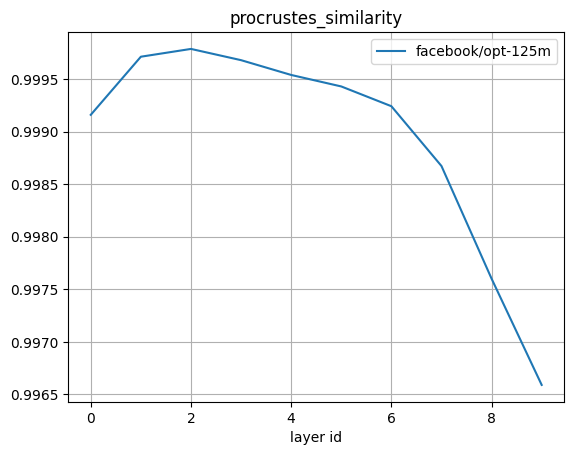

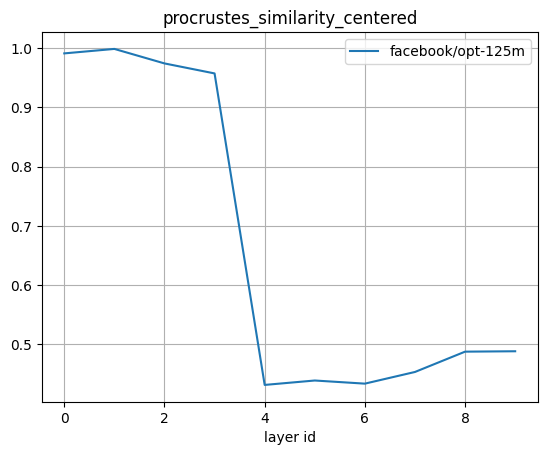

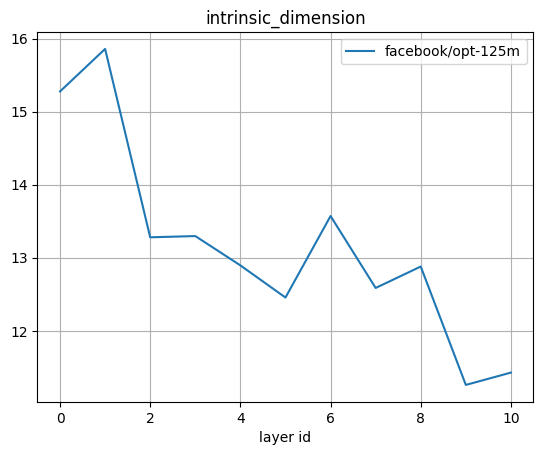

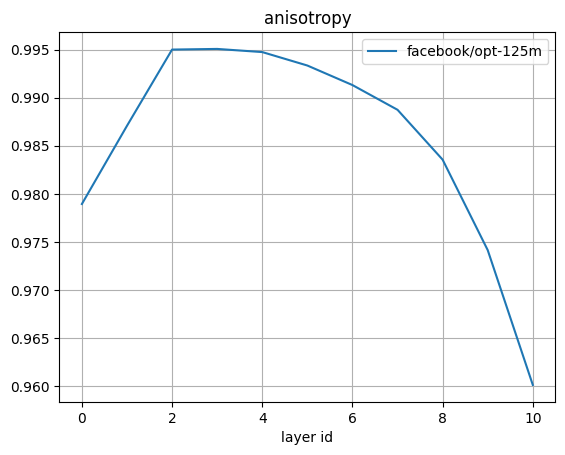

In [ ]:
for metric_name in all_results.keys():
    plt.title(metric_name)
    plt.grid()
    plt.xlabel("layer id")
    for model_name in all_results[metric_name].keys():
        plt.plot(all_results[metric_name][model_name][1:], label=model_name)
    plt.legend()
    plt.show()

## Logit Lens

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = 'cuda:1'
model_name = "facebook/opt-6.7b"
tokenizer= AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).bfloat16().to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


<Figure size 640x480 with 0 Axes>

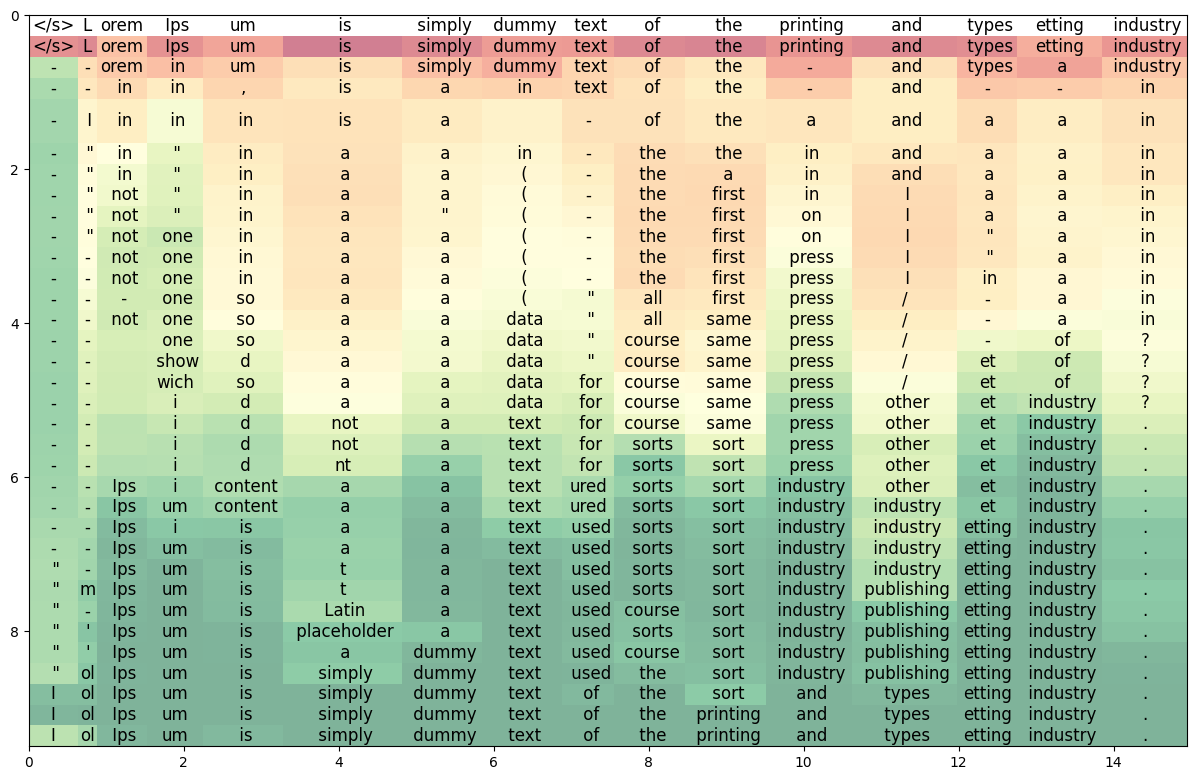

In [ ]:
from logit_lens import logit_lens, normalize_weights, plot_word_table, replace_bad_chars
text = "Lorem Ipsum is simply dummy text of the printing and typesetting industry."
tokens = tokenizer.encode(text)
words = [tokenizer.decode([tok]) for tok in tokens]
words = [replace_bad_chars(word) for word in words]

predictions, losses, decoded_words = logit_lens(model, tokenizer, text)
losses = normalize_weights(-losses, normalization_type="global") 

plot_word_table(decoded_words, losses, words)